## Graph clustering checking

Use the 3 years boardex data to check SBM library

And also mixed membership here, to try out the feature approaches

https://graph-tool.skewed.de

Use graph tools for use try this here, for best partitions

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import networkx as nx
pd.set_option('display.max_columns', None)

In [2]:
file_path = "../2.Initial_Graph_Building/boardex_us_companies_full_data_2022_2024.csv"

boardex_data = pd.read_csv(file_path, index_col = 0)

# Display the first few rows of the data to understand its structure
boardex_data.head()

,associationtype,boardname,companyname,directorname,overlapyearstart,overlapyearend,role,associatedrole,conncompanyorgtype,boardid,companyid,directorid,roletitle,roleboardposition,roleedflag,overlapyearstart_int,overlapyearend_int,startcompanydatestartrole,startcompanydateendrole,conncompanydatestartrole,conncompanydateendrole,orgtype
0,Unlisted Org,VERICEL CORP (Aastrom Biosciences Inc prior to...,Gladius Pharmaceuticals Inc,Doctor Steve Gilman,2020,Curr,Independent Director (Brd) (SD),Scientific Advisor (Non-Brd),Private,401.0,2734400.0,601453.0,Independent Director,Brd,SD,2020,NaN,2015-01-06,NaN,NaN,NaN,Quoted
1,Unlisted Org,VERICEL CORP (Aastrom Biosciences Inc prior to...,ContraFect Corp,Doctor Steve Gilman,2023,Curr,Independent Director (Brd) (SD),Independent Vice Chairman (Brd) (SD),Private,401.0,3700766.0,601453.0,Independent Director,Brd,SD,2023,NaN,2015-01-06,NaN,2023-11-09,NaN,Quoted
2,Other,VERICEL CORP (Aastrom Biosciences Inc prior to...,Northeastern University,Doctor Steve Gilman,2016,Curr,Independent Director (Brd) (SD),Advisory Board Member,Universities,401.0,61472.0,601453.0,Independent Director,Brd,SD,2016,NaN,2015-01-06,NaN,NaN,NaN,Quoted
3,Listed Org,VERICEL CORP (Aastrom Biosciences Inc prior to...,AKEBIA THERAPEUTICS INC,Doctor Steve Gilman,2018,Curr,Independent Director (Brd) (SD),Independent Director (Brd) (SD),Quoted,401.0,2055831.0,601453.0,Independent Director,Brd,SD,2018,NaN,2015-01-06,NaN,2018-12-12,NaN,Quoted
4,Listed Org,VERICEL CORP (Aastrom Biosciences Inc prior to...,SCYNEXIS INC,Doctor Steve Gilman,2015,Curr,Independent Director (Brd) (SD),Independent Director (Brd) (SD),Quoted,401.0,2065362.0,601453.0,Independent Director,Brd,SD,2015,NaN,2015-01-06,NaN,2015-02-25,NaN,Quoted


In [3]:
boardex_data.columns

Index(['associationtype', 'boardname', 'companyname', 'directorname',
       'overlapyearstart', 'overlapyearend', 'role', 'associatedrole',
       'conncompanyorgtype', 'boardid', 'companyid', 'directorid', 'roletitle',
       'roleboardposition', 'roleedflag', 'overlapyearstart_int',
       'overlapyearend_int', 'startcompanydatestartrole',
       'startcompanydateendrole', 'conncompanydatestartrole',
       'conncompanydateendrole', 'orgtype'],
      dtype='object')

Watch out for the column details here that's it. Ignore the other metrics later.

In [4]:
filtered_data_df = boardex_data[['boardid', 'companyid', 'directorid', 'overlapyearstart', 'overlapyearend' ]].drop_duplicates()

In [5]:
filtered_data_df['overlapyearend'].replace("Curr", 2024)
filtered_data_df['overlapyearstart'] = pd.to_numeric(filtered_data_df['overlapyearstart'], errors='coerce')
filtered_data_df['overlapyearend'] = pd.to_numeric(filtered_data_df['overlapyearend'], errors='coerce')

### Build Board graph (company interlock)

Here we build the graph with networkx and visualise the results

If this works we can then create an edge list for 

In [6]:
simplified_boardex_df = filtered_data_df.copy()

In [7]:
year = 2022

In [8]:
graph_simplified_df = simplified_boardex_df[ (year >= simplified_boardex_df['overlapyearstart']) & (year < simplified_boardex_df['overlapyearend'])] # less as otherwise overlap to next year


In [9]:
# above will fix the overlap issue - make sure to this!!

In [10]:
graph_simplified_df.sort_values(["boardid", "companyid"]).head()

,boardid,companyid,directorid,overlapyearstart,overlapyearend
45,401.0,462825.0,2119563.0,2022,2024.0
8,401.0,2129204.0,601453.0,2022,2023.0
41,401.0,3179994.0,1330373.0,2021,2023.0
33,401.0,3347021.0,323007.0,2022,2023.0
98,569.0,23423.0,2535310.0,2022,2023.0


In [146]:
len(list(set(graph_simplified_df.boardid.to_list() + graph_simplified_df.companyid.to_list()))) # why are there so many more companies?, is it because of filtering on one side?

# if so more diversity than previously reviewed

8967

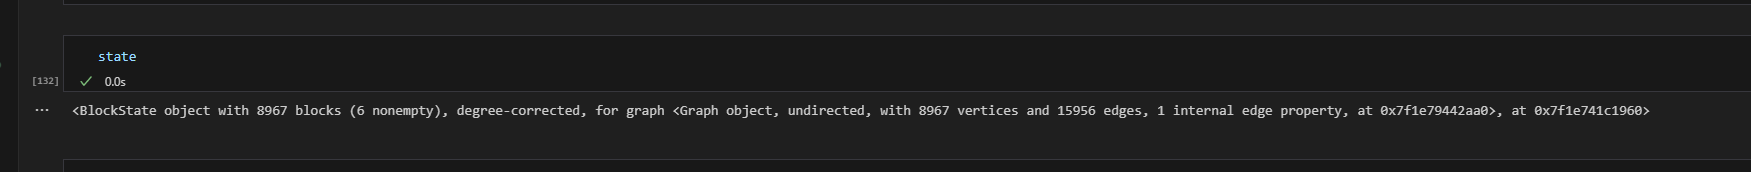

This matches with the number of nodes in the original data, so nothing wrong here!! Just data querying messed it up!!

In [11]:
# this really fast - so more graphs it should still be fine - try it after!!

In [12]:
# can use gpu supported output here if needed later

# https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html

In [13]:
G = nx.from_pandas_edgelist(graph_simplified_df, 'boardid', 'companyid', edge_attr='directorid')

# Generate Adjacency Matrix
adj_matrix = nx.adjacency_matrix(G)

In [14]:
adj_matrix.todense().shape

(8967, 8967)

In [15]:
set(adj_matrix.todense().flatten())

{0, 1}

#### Review Stochastic BlockModel

Write the structure here for MCMC in the dissertation article

https://graph-tool.skewed.de/static/doc/demos/inference/inference.html

https://bbengfort.github.io/2016/06/graph-tool-from-networkx/

https://graph-tool.skewed.de/static/doc/quickstart.html

In [60]:
import graph_tool as gt

from graph_tool.all import Graph, graph_draw

In [61]:
ug = Graph(directed=False)

In [62]:
ug = Graph(adj_matrix, directed = False) # put adjacency matrix in

# just try the networkx to create the ajdency matrix, and use graph tool to to more sophisticated approaches

In [63]:
ug # same get edge objects etc.

<Graph object, undirected, with 8967 vertices and 15956 edges, 1 internal edge property, at 0x7f1e79442aa0>

In [64]:
ug.vp

{}

Drawing graphs for analysis

https://graph-tool.skewed.de/static/doc/quickstart.html#example-analysis-an-online-social-network

Use relevant analysis above.

Layouts:

Use the following for the layout

https://graph-tool.skewed.de/static/doc/draw.html#graph-tool-draw

See which layout is most useful

**Conclusion**

Visualisation and everything else is fast - so could use this for later, for more meaningful analyses

Use Networkx as a data loader here.

**Other modules**

Look at other modules for more meaningful grapyh functionalities including clustering

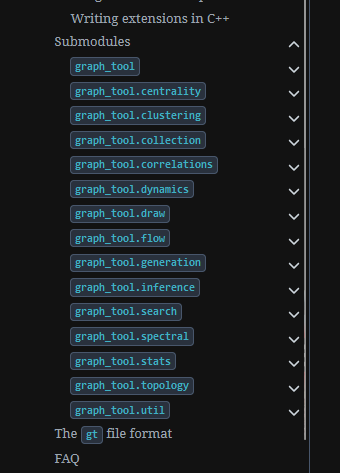

https://graph-tool.skewed.de/static/doc/quickstart.html#example-analysis-an-online-social-network

In [65]:
graph_draw(ug, output="boardex_test.pdf") # try giving the position as needed # interesting visualisations - so it is well connected.

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1e79442aa0, at 0x7f1f272ac5e0>

In [66]:
# can visualise it well as well.

# As seen in the PDF, so use these for analysis

#### Clustering with basic SBM implementation

Look at meaningful SBM with a yearly approach, see if it is meaningful.

In [67]:
gt.all.minimize_blockmodel_dl # use gt.all as gt instead of the regular package,

# they probably have everything 

<function graph_tool.inference.minimize.minimize_blockmodel_dl(g, state=<class 'graph_tool.inference.blockmodel.BlockState'>, state_args={}, multilevel_mcmc_args={})>

In relation to the below

https://graph-tool.skewed.de/static/doc/demos/inference/inference.html

Runs incredibly fast only couple of seconds that is amazing, need to use this implementaton in the future

### Problem:

It is random, we get different partitions each time!!

In [80]:
# also we see different results each time, which is problematic

In [92]:
help( gt.all.minimize_blockmodel_dl)

Help on function minimize_blockmodel_dl in module graph_tool.inference.minimize:

minimize_blockmodel_dl(g, state=<class 'graph_tool.inference.blockmodel.BlockState'>, state_args={}, multilevel_mcmc_args={})
    Fit the stochastic block model, by minimizing its description length using an
    agglomerative heuristic.
    
    Parameters
    ----------
    g : :class:`~graph_tool.Graph`
        The graph.
    state : SBM-like state class (optional, default: :class:`~graph_tool.inference.BlockState`)
        Type of model that will be used. Must be derived from :class:`~graph_tool.inference.MultilevelMCMCState`.
    state_args : ``dict`` (optional, default: ``{}``)
        Arguments to be passed to appropriate state constructor (e.g.
        :class:`~graph_tool.inference.BlockState`)
    multilevel_mcmc_args : ``dict`` (optional, default: ``{}``)
        Arguments to be passed to :meth:`~graph_tool.inference.MultilevelMCMCState.multilevel_mcmc_sweep`.
    
    Returns
    -------
    min

In [ ]:
# can set the seed to get consistent results

In [ ]:
gt.seed_rng(43)
np.random.seed(43)

In [97]:
desired_blocks = 2

In [106]:
bs = gt.inference.BlockState(ug, B = 2)

In [98]:
# state = gt.all.minimize_blockmodel_dl(ug) # to get the meaingful partitions and vaisualise the output

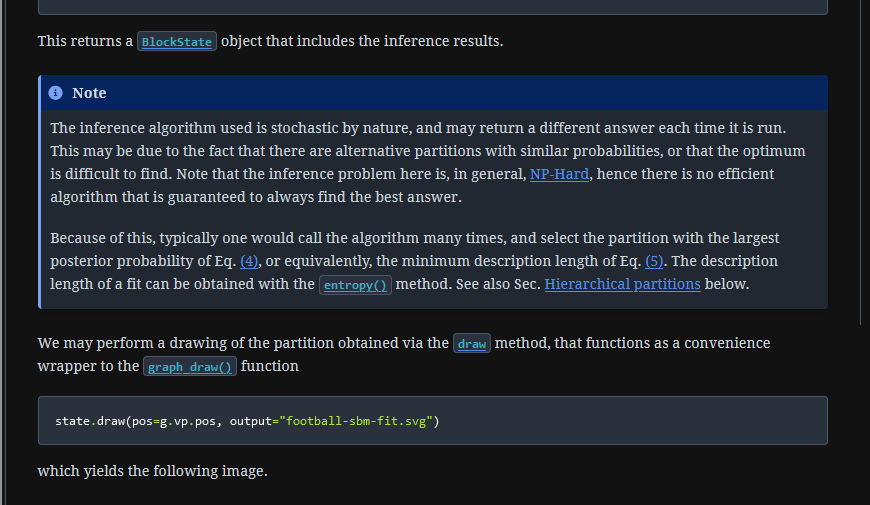

Use the justification above to get the best answer - sometimes 2 etc.

**That is the measure of quality here so it is useful to use that**

In [129]:
state = gt.all.minimize_blockmodel_dl(ug)
                                      
                                      #, state_args={"B" : 2}) # nothing works use the justification given above

In [ ]:
# 100 times and select the best and interpret those reults for the measures of quality that's !!

In [132]:
state

<BlockState object with 8967 blocks (6 nonempty), degree-corrected, for graph <Graph object, undirected, with 8967 vertices and 15956 edges, 1 internal edge property, at 0x7f1e79442aa0>, at 0x7f1e741c1960>

In [133]:
state.entropy()

99221.68017707142

In [134]:
# doesn't actually get anything meaningful just connected with everything!!

In [135]:
b = state.get_blocks()

In [136]:
b

<VertexPropertyMap object with value type 'int32_t', for Graph 0x7f1e79442aa0, at 0x7f1e741aa530>

In [137]:
set(list(b)) # either one or the other that's it!!

{679, 2072, 6912, 7306, 7515, 7612}

In [138]:
len(list(b))

8967

In [139]:
from collections import Counter

In [140]:
block_count = Counter(list(b))

In [141]:
block_count.keys(), block_count.values()

(dict_keys([7612, 679, 6912, 2072, 7515, 7306]),
 dict_values([335, 347, 1040, 246, 6912, 87]))

In [142]:
help(state.draw)

Help on method draw in module graph_tool.inference.base_states:

draw(**kwargs) method of graph_tool.inference.blockmodel.BlockState instance
    Convenience wrapper to :func:`~graph_tool.draw.graph_draw` that
    draws the state of the graph as colors on the vertices and edges.



In [143]:
state.draw(output="boardex-sbm.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1e79442aa0, at 0x7f1e741c2890>

For 6 nodes, we see that there is meaningful structure of key players, so could be useful here

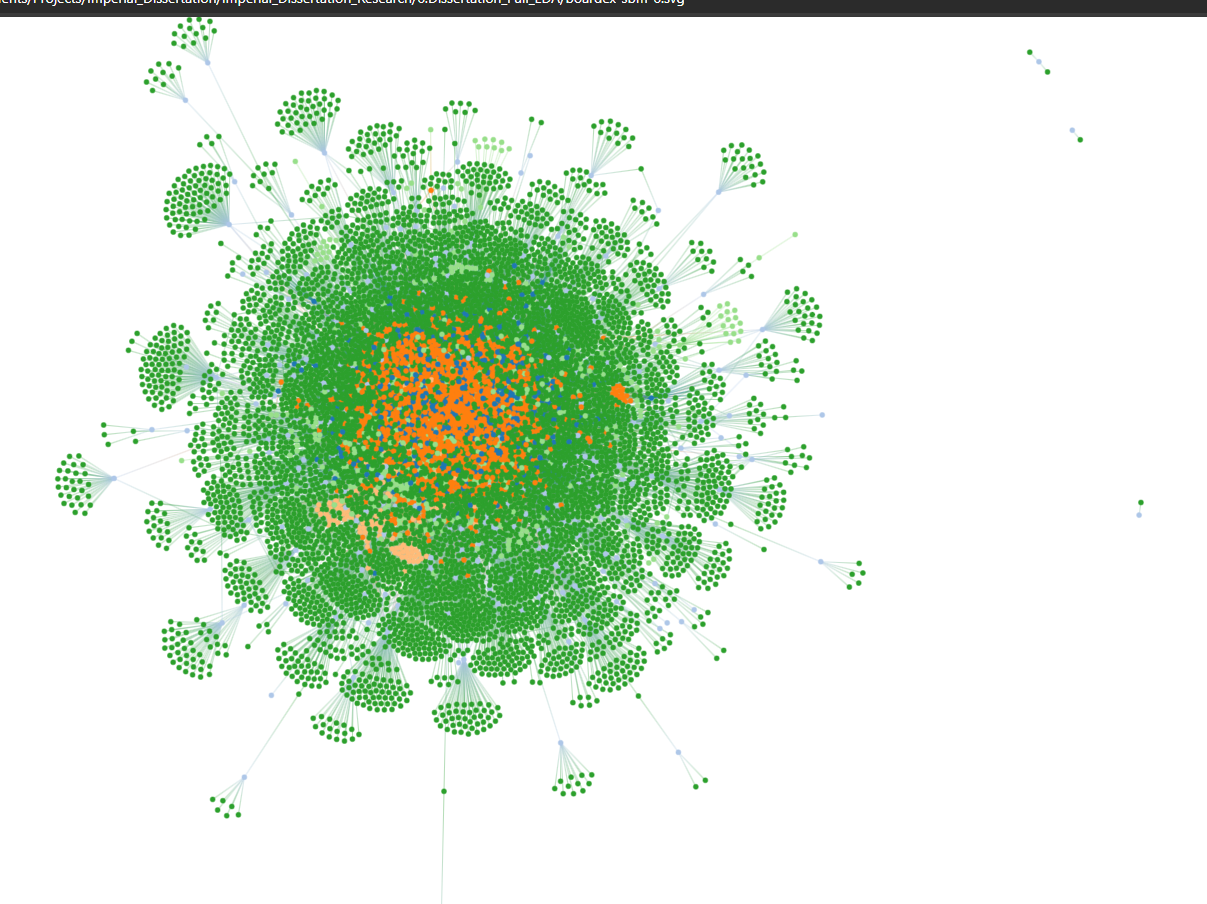

Read the documentation more carefully to understand how this works - and then try to get meaningful structures later!!

**Also see if annual approach works, or do each together?**

Also try other models like the Mixed Membership SBM model, and also another model? Exponential random graph

Betweenness measures

We can also get betweenness statistics as seen below

In [32]:
vb, eb = gt.all.betweenness(ug)

In [33]:
vb

<VertexPropertyMap object with value type 'double', for Graph 0x7f1ee8eea350, at 0x7f1e79440610>

## Next steps

Check if there is a way to find the best fit (select best block)

Also look at the issue of how to convert everything into a dictionary to do analysis of each cluster, which could be useful

### Football Test

In [51]:
g = gt.collection.data["football"]

In [52]:
print(g)

<Graph object, undirected, with 115 vertices and 613 edges, 4 internal vertex properties, 2 internal graph properties, at 0x7f1ee8ee9de0>


In [54]:
state = gt.all.minimize_blockmodel_dl(g)

In [55]:
state

<BlockState object with 115 blocks (10 nonempty), degree-corrected, for graph <Graph object, undirected, with 115 vertices and 613 edges, 4 internal vertex properties, 2 internal graph properties, at 0x7f1ee8ee9de0>, at 0x7f1e79442500>

In [56]:
state.draw(pos=g.vp.pos, output="football-sbm-fit.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1ee8ee9de0, at 0x7f1e9407a770>

# Other resources

Here are some other resources that can be used for how to use graph tools for further analysis

https://github.com/eliaswalyba/graph-tool-quickstart/blob/master/graph-tool.quickstart.ipynb

Another useful documentation to simplify use of graph tools

https://robert-haas.github.io/gravis-docs/code/examples/external_tools/graph-tool.html

The above in particular will be quite useful - 

```
state = gt.inference.EMBlockState(g, B=3)  # B is number of desired blocks
node_property_map_expectations = state.get_vertex_marginals()
```

Also graphing libary can use together with the analysis

Graph tools with pandas

https://rodogi.github.io/post/graph-tool/ Read from table if needed.

https://stackoverflow.com/questions/45372889/generating-graph-tool-graph-from-pandas-dataframe-or-csv

Save loaded partitions from Perplexity, you can try this later!!

Yes, there are examples of saving the partitions of a stochastic block model (SBM) from `graph-tool` such that they can be used later. Here is a detailed explanation of how you can achieve this:

### Saving the Partitions

To save the partitions of an SBM, you can use the `state.get_blocks()` method to get the partition assignments and then save these assignments along with the graph. Here's a step-by-step example:

1. **Fit the SBM to your graph**:
   ```python
   import graph_tool.all as gt

   g = gt.collection.data["football"]
   state = gt.minimize_blockmodel_dl(g)
   ```

2. **Retrieve the partition assignments**:
   ```python
   blocks = state.get_blocks()
   ```

3. **Save the graph and the partition assignments**:
   ```python
   g.save("graph.xml.gz")
   blocks.a.tofile("partitions.dat")
   ```

### Loading the Partitions

To load the partitions later, you can read the graph and the partition assignments from the saved files:

1. **Load the graph**:
   ```python
   g = gt.load_graph("graph.xml.gz")
   ```

2. **Load the partition assignments**:
   ```python
   import numpy as np

   blocks = g.new_vertex_property("int")
   blocks.a = np.fromfile("partitions.dat", dtype=int)
   ```

3. **Recreate the state with the loaded partitions**:
   ```python
   state = gt.BlockState(g, b=blocks)
   ```

### Example Code

Here is a complete example that demonstrates saving and loading the partitions:

```python
import graph_tool.all as gt
import numpy as np

# Create and fit the SBM
g = gt.collection.data["football"]
state = gt.minimize_blockmodel_dl(g)

# Save the graph and partitions
g.save("graph.xml.gz")
blocks = state.get_blocks()
blocks.a.tofile("partitions.dat")

# Load the graph and partitions
g_loaded = gt.load_graph("graph.xml.gz")
blocks_loaded = g_loaded.new_vertex_property("int")
blocks_loaded.a = np.fromfile("partitions.dat", dtype=int)

# Recreate the state with the loaded partitions
state_loaded = gt.BlockState(g_loaded, b=blocks_loaded)

# Verify the loaded state
print(state_loaded.get_blocks().a)
```

This approach ensures that you can save the state of your SBM partitions and reload them later for further analysis or visualization.

Citations:
[1] https://graph-tool.skewed.de/static/doc/demos/inference/inference.html
[2] https://graph-tool.skewed.de/static/doc/quickstart.html

### Graph approach here

In particular try the graph approach above in order to save the partition states and re-run it at a later date - rather than trying everything, and no replicable

Try meaningful results as well.